In [1]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import random
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw

In [4]:
# connect to chembl api
molecule = new_client.molecule

#limit to 100k
all_mols = molecule.filter(max_phase__gte=1)
print(f"Fetched {len(all_mols)} molecules from ChEMBL")

#extract relevant data
chembl_ids = []
smiles_list = []

for m in all_mols:

    try:
        chembl_id = m['molecule_chembl_id']

        smiles = m.get('molecule_structures', {}).get('canonical_smiles', None)
        if smiles:
            chembl_ids.append(chembl_id)
            smiles_list.append(smiles)
    
    except:
        continue

print(f"Extracted {len(smiles_list)} molecules with valid SMILES")

#convert to dataframe
df = pd.DataFrame({
    'molecule_chembl_id': chembl_ids,
    'canonical_smiles':smiles_list
})

#sample at most 50k
sample_size = min(50000, len(df))
df_sample = df.sample(sample_size, random_state=42).reset_index(drop=True)
print(f"Sampled {len(df_sample)} molecules")

df_sample.head()

Fetched 16754 molecules from ChEMBL
Extracted 12761 molecules with valid SMILES
Sampled 12761 molecules


,molecule_chembl_id,canonical_smiles
0,CHEMBL4297525,NC(=O)C1(NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](Cc...
1,CHEMBL5095226,O=C1CC[C@H](N2C(=O)c3cccc(NCc4ccc(CN5CC(N6CCOC...
2,CHEMBL1697754,CC(C)OC(=O)C(C(=O)OC(C)C)=C1SC=CS1
3,CHEMBL258918,C[C@H]1CC(=O)C[C@@H]2CC[C@H]3[C@@H]4CC[C@H](O)...
4,CHEMBL297550,COc1c2occc2c(OC)c2c(=O)cc(CSC)oc12


In [5]:
#compute molecular properties
def compute_properties(smiles):

    try:
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            return None
        
        return{
            'logP': Descriptors.MolLogP(mol),
            'MW': Descriptors.MolWt(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
        } #return dictionary of properties
    
    except:
        return None
    

props = df_sample['canonical_smiles'].apply(compute_properties)
props_df = pd.DataFrame([p for p in props if p is not None])

#combine properties with original dataframe
df_final = pd.concat([df_sample.reset_index(drop=True), props_df.reset_index(drop=True)], axis=1)

# Drop molecules where RDKit failed
df_final = df_final.dropna(subset=['logP','MW','HBD','HBA']).reset_index(drop=True)
print(f"Final dataset size: {len(df_final)} molecules")

# csv saved
df_final.to_csv('chembl_for_agents.csv', index=False)
print("Datasets saved: chembl_for_agent.csv")


[13:09:40] WARNING: not removing hydrogen atom without neighbors
[13:09:41] WARNING: not removing hydrogen atom without neighbors
[13:09:41] WARNING: not removing hydrogen atom without neighbors
[13:09:41] WARNING: not removing hydrogen atom without neighbors
[13:09:41] WARNING: not removing hydrogen atom without neighbors
[13:09:41] WARNING: not removing hydrogen atom without neighbors
[13:09:41] WARNING: not removing hydrogen atom without neighbors
[13:09:41] WARNING: not removing hydrogen atom without neighbors


Final dataset size: 12761 molecules
Datasets saved: chembl_for_agent.csv


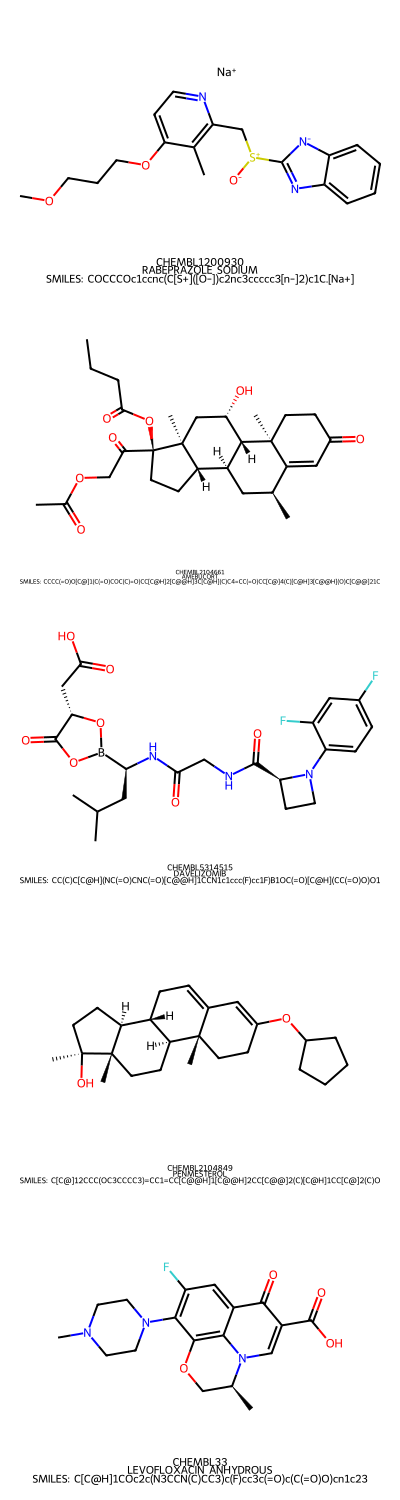

In [4]:
#visualise some molecules

#load dataset
df = pd.read_csv('chembl_for_agents.csv')
molecule = new_client.molecule

#randomly pick 5 molecules
sample_df = df.sample(5)

verified_imgs = []
labels = []

for _, row in sample_df.iterrows():
    chembl_id = row['molecule_chembl_id']
    smiles = row['canonical_smiles']

    #fetch name from chembl
    mol_info = molecule.get(chembl_id)
    mol_name = mol_info.get('pref_name', 'Unknown')

    #generate image
    mol = Chem.MolFromSmiles(smiles)

    if mol:
        verified_imgs.append(mol)
        labels.append(f"{chembl_id}\n{mol_name}\nSMILES: {smiles}")
    else:
        print(f"Failed to generate molecule for {chembl_id}")

#draw molecules
img = Draw.MolsToGridImage(verified_imgs, molsPerRow=1, legends=labels, subImgSize=(400, 300))
img